# Assignment 2

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Keywords**: Transformers, Question Answering, CoQA

## Task and dataset explanation

### Overview

### Problem

Question Answering (QA) on [CoQA](https://stanfordnlp.github.io/coqa/) dataset: a conversational QA dataset.

### Task

Given a question $Q$, a text passage $P$, the task is to generate the answer $A$.<br>
$\rightarrow A$ can be: (i) a free-form text or (ii) unanswerable;

**Note**: an question $Q$ can refer to previous dialogue turns. <br>
$\rightarrow$ dialogue history $H$ may be a valuable input to provide the correct answer $A$.

### Models

We are going to experiment with transformer-based models to define the following models:

1.  $A = f_\theta(Q, P)$

2. $A = f_\theta(Q, P, H)$

where $f_\theta$ is the transformer-based model we have to define with $\theta$ parameters.

### The CoQA dataset

<center>
    <img src="https://drive.google.com/uc?export=view&id=16vrgyfoV42Z2AQX0QY7LHTfrgektEKKh" width="750"/>
</center>

For detailed information about the dataset, feel free to check the original [paper](https://arxiv.org/pdf/1808.07042.pdf).



### Rationales

Each QA pair is paired with a rationale $R$: it is a text span extracted from the given text passage $P$. <br>
$\rightarrow$ $R$ is not a requested output, but it can be used as an additional information at training time!

### Dataset Statistics

* **127k** QA pairs.
* **8k** conversations.
* **7** diverse domains: Children's Stories, Literature, Mid/High School Exams, News, Wikipedia, Reddit, Science.
* Average conversation length: **15 turns** (i.e., QA pairs).
* Almost **half** of CoQA questions refer back to **conversational history**.
* Only **train** and **validation** sets are available.

### Dataset snippet

The dataset is stored in JSON format. Each dialogue is represented as follows:

```
{
    "source": "mctest",
    "id": "3dr23u6we5exclen4th8uq9rb42tel",
    "filename": "mc160.test.41",
    "story": "Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. 
    Cotton lived high up in a nice warm place above the barn where all of the farmer's horses slept. [...]" % <-- $P$
    "questions": [
        {
            "input_text": "What color was Cotton?",   % <-- $Q_1$
            "turn_id": 1
        },
        {
            "input_text": "Where did she live?",
            "turn_id": 2
        },
        [...]
    ],
    "answers": [
        {
            "span_start": 59,   % <-- $R_1$ start index
            "spand_end": 93,    % <-- $R_1$ end index
            "span_text": "a little white kitten named Cotton",   % <-- $R_1$
            "input_text" "white",   % <-- $A_1$      
            "turn_id": 1
        },
        [...]
    ]
}
```

### Simplifications

Each dialogue also contains an additional field ```additional_answers```. For simplicity, we **ignore** this field and only consider one groundtruth answer $A$ and text rationale $R$.

CoQA only contains 1.3% of unanswerable questions. For simplicity, we **ignore** those QA pairs.

## List of tasks

### [Task 1] Remove unaswerable QA pairs 

Write your own script to remove unaswerable QA pairs from both train and validation sets. 

### [Task 2] Train, Validation and Test splits

CoQA only provides a train and validation set since the test set is hidden for evaluation purposes.

We'll consider the provided validation set as a test set. <br>
$\rightarrow$ Write your own script to:
* Split the train data in train and validation splits (80% train and 20% val)
* Perform splits such that a dialogue appears in one split only! (i.e., split at dialogue level)
* Perform splitting using the following seed for reproducibility: 42

#### Reproducibility Memo

Check back tutorial 2 on how to fix a specific random seed for reproducibility!

### [Task 3] Model definition

Write your own script to define the following transformer-based models from [huggingface](https://HuggingFace.co/).

* [M1] DistilRoBERTa (distilberta-base)
* [M2] BERTTiny (bert-tiny)

**Note**: Remember to install the ```transformers``` python package!

**Note**: We consider small transformer models for computational reasons!

### [Task 4] Question generation with text passage $P$ and question $Q$

We want to define $f_\theta(P, Q)$. 

Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$ and $Q_i$ and generate $A_i$.

### [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

We want to define $f_\theta(P, Q, H)$. Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$, $Q_i$, and $H = \{ Q_0, A_0, \dots, Q_{i-1}, A_{i-1} \}$ to generate $A_i$.

### [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

Write your own script to train and evaluate your $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$ models.

### Instructions

* Perform multiple train/evaluation seed runs: [42, 2022, 1337].$^1$
* Evaluate your models with the following metrics: SQUAD F1-score.$^2$
* Fine-tune each transformer-based models for **3 epochs**.
* Report evaluation SQUAD F1-score computed on the validation and test sets.

$^1$ Remember what we said about code reproducibility in Tutorial 2!

$^2$ You can use ```allennlp``` python package for a quick implementation of SQUAD F1-score: ```from allennlp_models.rc.tools import squad```. 

### [Task 7] Error Analysis

Perform a simple and short error analysis as follows:
* Group dialogues by ```source``` and report the worst 5 model errors for each source (w.r.t. SQUAD F1-score).
* Inspect observed results and try to provide some comments (e.g., do the models make errors when faced with a particular question type?)$^1$

$^1$ Check the [paper](https://arxiv.org/pdf/1808.07042.pdf) for some valuable information about question/answer types (e.g., Table 6, Table 8) 

## Dataset Download


In [1]:
import os
import os.path
import json
import typing
import urllib.request
import random

import keras.callbacks
import keras.layers
import keras.losses
import keras.optimizers
import keras.regularizers
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

In [2]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [3]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

coqa-train-v1.0.json: 49.0MB [00:06, 7.92MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:01, 6.86MB/s]                            

Download completed!


## Create the dataframe, inspect the data and do some preprocessing [TASK 1, TASK 2]

In [4]:
train_path = './coqa/train.json'
test_path = './coqa/test.json'

with open(train_path, 'r') as f:
    train_json = json.load(f)

with open(test_path, 'r') as f:
    test_json = json.load(f)


Given that the dataset is provided as a json file we decided to unpack it with a first rough operation creating a column of a DataFrame for each key of the dictionary.

In [5]:
df_train = pd.json_normalize(train_json['data'])
df_test = pd.json_normalize(test_json['data'])
# We need a different DataFrame that consider also the 'source' for the final evaluation
df_final_evaluation = df_test.copy()

df_train.head()

,source,id,filename,story,questions,answers,name
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",[{'input_text': 'When was the Vat formally ope...,"[{'span_start': 151, 'span_end': 179, 'span_te...",Vatican_Library.txt
1,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,cnn_fe05c61a7e48461f7883cdec387567029614f07b.s...,New York (CNN) -- More than 80 Michael Jackson...,"[{'input_text': 'Where was the Auction held?',...","[{'span_start': 243, 'span_end': 284, 'span_te...",cnn_fe05c61a7e48461f7883cdec387567029614f07b.s...
2,gutenberg,3bdcf01ogxu7zdn9vlrbf2rqzwplyf,data/gutenberg/txt/Zane Grey___Riders of the P...,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",[{'input_text': 'What did Venters call Lassite...,"[{'span_start': 841, 'span_end': 880, 'span_te...",data/gutenberg/txt/Zane Grey___Riders of the P...
3,cnn,3ewijtffvo7wwchw6rtyaf7mfwte0p,cnn_0c518067e0df811501e46b2e1cd1ce511f1645b7.s...,(CNN) -- The longest-running holiday special s...,"[{'input_text': 'Who is Rudolph's father?', 't...","[{'span_start': 500, 'span_end': 557, 'span_te...",cnn_0c518067e0df811501e46b2e1cd1ce511f1645b7.s...
4,gutenberg,3urfvvm165iantk80llvkwwbjs7uzh,data/gutenberg/txt/Rafael Sabatini___Love-at-A...,CHAPTER XXIV. THE INTERRUPTED MASS \n\nThe mor...,"[{'input_text': 'Who arrived at the church?', ...","[{'span_start': 254, 'span_end': 297, 'span_te...",data/gutenberg/txt/Rafael Sabatini___Love-at-A...


As we can see, the sources for the dialogues are only five and they provide almost the same number of dialogues, apart from 'mctest'

In [6]:
df_train['source'].value_counts()

race         1711
cnn          1702
wikipedia    1621
gutenberg    1615
mctest        550
Name: source, dtype: int64

We can also explore the number of dialogues and the average lenght of question-answer pairs for the training set.

In [7]:
print(f"- The training set contains {len(df_train)} dialogues.\n")
print(f"- On average we have {round(df_train['questions'].apply(lambda x: len(x)).mean(),2)}"
      f" question-answer pairs for each dialogue.")

- The training set contains 7199 dialogues.

- On average we have 15.09 question-answer pairs for each dialogue.


In the dataset above we have some features that are not useful for our task therefore we decided to remove them and we remained with the story for each dialogue, the questions and the relative answers.

In [8]:
features_to_remove = ['source', 'id', 'filename', 'name']
features_to_remove_test = features_to_remove + [f'additional_answers.{i}' for i in range(3)]

df_train.drop(features_to_remove, axis=1, inplace=True)
df_test.drop(features_to_remove_test, axis=1, inplace=True)
df_final_evaluation.drop(features_to_remove_test[1:], axis=1, inplace=True)

In [9]:
df_train.head()

,story,questions,answers
0,"The Vatican Apostolic Library (), more commonl...",[{'input_text': 'When was the Vat formally ope...,"[{'span_start': 151, 'span_end': 179, 'span_te..."
1,New York (CNN) -- More than 80 Michael Jackson...,"[{'input_text': 'Where was the Auction held?',...","[{'span_start': 243, 'span_end': 284, 'span_te..."
2,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",[{'input_text': 'What did Venters call Lassite...,"[{'span_start': 841, 'span_end': 880, 'span_te..."
3,(CNN) -- The longest-running holiday special s...,"[{'input_text': 'Who is Rudolph's father?', 't...","[{'span_start': 500, 'span_end': 557, 'span_te..."
4,CHAPTER XXIV. THE INTERRUPTED MASS \n\nThe mor...,"[{'input_text': 'Who arrived at the church?', ...","[{'span_start': 254, 'span_end': 297, 'span_te..."


At this point we can split the dataset in training and validation as stated in the assignment, we do that operation here because the questions are still grouped in dialogues therefore we put all the questions from one dialogue either in validation or in the training set, as specified in ***Task 2***.

In [10]:
seeds = [42, 2022, 1337]

def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [11]:
def split_train_validation(df: pd.DataFrame, val_size: float=0.2) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    '''
        It takes as input a dataframe and it splits it in 2 dataframes considering the 
        'val_size' parameter. 
    '''

    validation = df.sample(frac=val_size) 
    training = df.drop(validation.index)

    assert training is not None, "The dataframe is None"
    # It shuffles the training set dialogues
    training = training.sample(frac=1)

    return training.reset_index(drop=True), validation.reset_index(drop=True)

Before splitting the training data in training and validation set we set the seed 42 for the reproducibility as requested.

In [12]:
set_reproducibility(seeds[0])
df_train, df_val = split_train_validation(df_train, 0.2)
print(f"The dimensions of the datasets are:\n"
     f"Training dataset -> {df_train.shape} - Validation dataset -> {df_val.shape}")

The dimensions of the datasets are:
Training dataset -> (5759, 3) - Validation dataset -> (1440, 3)


We still have to unpack the array of questions and answers in order to create a row for each single element and we need to remove the unanswerable questions from the data.
- The first function is a helper that allows us to create different rows of a DataFrame from a list of questions. 
- The second one is used to remove the unanswerable questions from the data, a question is ***unanswerable*** if the 'span_start' feature is -1.

In [13]:
def expand_lists(df: pd.DataFrame, to_drop: typing.List[str]=[],
                 for_eval: bool=False) -> pd.DataFrame:
    '''
        Given a Pandas dataframe it returns a new dataframe with the expansion of
        the questions and the answers and removing the desired columns.
    '''
    if for_eval:
        # Add also the 'source' feature
        assert 'source' in df.columns, "The DataFrame has not the 'source' feature"
        questions = [{'source': df.source[i], 'story':df.story[i], **quest} 
                        for i, lis in enumerate(df.questions) for quest in lis]
    else:
        # Create a dictionary with the story and the other features for each question
        questions = [{'story':df.story[i], **quest} for i, lis in enumerate(df.questions) for quest in lis]

    answers = [ans for lis in df.answers for ans in lis]

    # Create a DataFrame from the previous dictionaries and remove useless features
    X = pd.DataFrame.from_dict(questions, orient="columns").drop(to_drop, axis=1)
    y = pd.DataFrame.from_dict(answers, orient="columns").drop(to_drop, axis=1)

    assert X is not None and y is not None, "The dataframe is None"
    
    X.rename(columns={'input_text':'questions'}, inplace=True)
    y.rename(columns={'input_text':'answers'}, inplace=True)
    
    return pd.concat([X, y], axis=1)


def remove_unanswerable(df: pd.DataFrame, verbose:bool=True) -> pd.DataFrame:
    '''
        It removes the unanswerable questions from the passed DataFrame
        removing the elements with 'span_start' < 0
    '''

    target = 'span_start'
    if target not in df.columns:
        print(
            "WARNING: the DataFrame doesn't have the 'span_start' column, the"
            " function will return the DataFrame without changes."
            )
        return df
        
    uns_rows = df[target] > 0
    if verbose:
        print(
            f"{len(df) - len(df[uns_rows])} unanswerable questions has been removed"
             " from the DataFrame."
            )
    return df[uns_rows].reset_index(drop=True)

In order to make the code as ordered as possible we implemented a unique function for the preprocessing that we need to apply on the different DataFrames. It simply calls the 2 previous functions on the passed DataFrame, it removes the features about the spans and it returns the new DataFrame.

In [14]:
def data_preprocessing(df: pd.DataFrame, to_drop: typing.List[str]=[],
                       for_eval: bool=False) -> pd.DataFrame:
    '''
        This function creates a DataFrame with a column for the 'story', one
        for the 'questions' and another for the 'answers' and it removes the
        unanswerable questions.
        Parameters:
            - df : pd.DataFrame
                The structure on which performing the operations.
            - to_drop: list[str]
                The names of the columns to drop.
            - for_eval: bool
                If the expand_lists function has to be run in evaluation mode,
                so we preserve the 'source' feature.
                
        Returns:
            pandas.Dataframe
                The modified dataframe.
    '''
    new_df = expand_lists(df, to_drop, for_eval)
    new_df = remove_unanswerable(new_df)

    span_feat = ['span_start', 'span_end', 'span_text']
    new_df.drop(span_feat, axis=1, inplace=True)

    return new_df

In [15]:
df_train = data_preprocessing(df_train, to_drop=['turn_id', 'bad_turn'])
df_val = data_preprocessing(df_val, to_drop=['turn_id', 'bad_turn'])
df_test = data_preprocessing(df_test, to_drop=['turn_id'])
df_final_evaluation = data_preprocessing(df_final_evaluation, to_drop=['turn_id'], for_eval=True)

print(f"\nThe training set has {len(df_train)} samples, the validation set has {len(df_val)} samples"
      f"and the test set has {len(df_test)} samples.")

3490 unanswerable questions has been removed from the DataFrame.
900 unanswerable questions has been removed from the DataFrame.
288 unanswerable questions has been removed from the DataFrame.
288 unanswerable questions has been removed from the DataFrame.

The training set has 83408 samples, the validation set has 20849 samplesand the test set has 7695 samples.


At this moment the DataFrame looks like this:

In [16]:
df_train.head()

,story,questions,answers
0,CHAPTER III. \n\nTHE NIGHT-WATCHERS. \n\nWhat ...,What color is the top of the church?,green
1,CHAPTER III. \n\nTHE NIGHT-WATCHERS. \n\nWhat ...,Is it short?,No
2,CHAPTER III. \n\nTHE NIGHT-WATCHERS. \n\nWhat ...,Who behaves better?,the back of the Tenements
3,CHAPTER III. \n\nTHE NIGHT-WATCHERS. \n\nWhat ...,Why?,Every back window in the Tenements has a glint...
4,CHAPTER III. \n\nTHE NIGHT-WATCHERS. \n\nWhat ...,Who killed himself?,Beattie


## Model implementation and data tokenization [TASK 3, TASK 4, TASK 5]

In order to train the encoder-decoder architecture we have to tokenize the samples such that we can give numbers as input to the network.

In our case we will use the tokenizer of the relative pre-trained model.

In [ ]:
!pip install transformers -q
!pip install datasets -q
import datasets

### Load the pre-trained model and tokenizer

In [40]:
from typing import Optional, Union, List, Tuple, Dict

from datasets.arrow_dataset import Dataset
from transformers import TFEncoderDecoderModel, AutoTokenizer

from keras.optimizers import Adam

In [41]:
#from google.colab import drive
#drive.mount('/content/drive')

drive_weights_path = "/content/drive/MyDrive/weights_NLP_assignments/"
drive_tokenized_path = "/content/drive/MyDrive/weights_NLP_assignments/tok_data/"

bertiny_name = "prajjwal1/bert-tiny"
roberta_name = "distilroberta-base"

We implemented a function to import the tokenizer and the model from a pre-saved model or directly from Huggingface if no path is passed.

In [42]:
def check_pretrained_path(path: str) -> bool:
    '''
        It checks if the config.json file exists in the current path.
    '''
    config_file = os.path.join(path, 'config.json')
    return os.path.exists(config_file)


def import_model_tokenizer(name: str="distilroberta-base", load_weights: Optional[str]=None)->tuple:
    '''
        It imports the tokenizer and the model specified from the 'name' parameter.
        If a path in 'load_weigths' is specified then it imports the model from
        a pre-saved file.
        Parameters:
            - name: str
                The name of the model we want to import, it must exist in the
                Huggingface database.
            - load_weights: str | None
                The path to a directory that contains the config file and the 
                .h5 file for loading a pre-saved model.
        
        Returns:
            - tuple
                It returns the desired tokenizer and the imported model.
    '''
    tokenizer = AutoTokenizer.from_pretrained(name)
    enc_from_pt = False

    # If a path has been passed
    if load_weights != None:
        mod_name = name.split('/')[-1]
        full_path = os.path.join(drive_weights_path, mod_name, load_weights)
        if check_pretrained_path(full_path):
            model = TFEncoderDecoderModel.from_pretrained(full_path)
        else:
            print("ERROR: Check if a config.json file exists in the given path.")
            return None, None
    else:
        if name != "distilroberta-base":
            enc_from_pt = True

        model = TFEncoderDecoderModel.from_encoder_decoder_pretrained(
            name, name, encoder_from_pt=enc_from_pt, decoder_from_pt=enc_from_pt
        )
        model.config.decoder_start_token_id = tokenizer.cls_token_id
        model.config.pad_token_id = tokenizer.pad_token_id
        model.config_eos_token_id = tokenizer.sep_token_id
        model.config.vocab_size = model.config.encoder.vocab_size



    return tokenizer, model

In [43]:
tokenizer, model = import_model_tokenizer(bertiny_name)#, load_weights='full_history')

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

### Tokenization function and history creation

The following function is needed to create the history for each sample, the history is composed by the 'story' of the question and all the questions and answers from the previous rows.
The function has 3 main steps:
- we group by 'story' in order to consider the samples belonging to the same dialogue; we create a new column 'history' in the DataFrame where we put for each line the concatenation of answer and question of the successive row. This because the first element of the history for each question is the previous one, so we need to shift by 1 such that we avoid to put the current question and answer in the history as well.
- Now, after having grouped by 'story' again, we apply the function *cumulative sum*, it sums the previous rows of the same group to the current one.
- As last step we sum the 'story' to the computed history and we return the DataFrame with the new column.

In [20]:
def create_history(df: pd.DataFrame, group: str='story') -> pd.DataFrame:
    '''
        This function returns the dataframe with a new column 'history' which
        contains the sum of the story and all the questions and answers within
        the same context, not considering the current sample.
        Parameters:
            - df: pd.DataFrame
                The dataframe from which the function takes the data.
            - group: str
                The column to consider for the groupby operation.
        
        Returns:
            - pd.DataFrame
                The DataFrame with the new column added. 
    '''
    new_df = df.copy()
    sum_columns = lambda x: x.questions + ' ' + x.answers + ' '
    # If the story has a white space at the end, we don't need to add it
    def sum_ctx_history(row):
        space = " "
        if row.story[-1].isspace():
            space = ""
        return row.story + space + row.history

    print("START: Creating the history column for the dataset...")
    # Returns a new column that contains for each sample the sum of the
    # question and the context
    new_df['history'] = new_df.groupby(group, axis=0, sort=False) \
                            .shift(fill_value='') \
                            .apply(sum_columns, axis=1)

    # Sum the history up to the previous question for each sample
    new_df['history'] = new_df.groupby(group, axis=0, sort=False)['history'] \
                            .apply(lambda x: x.cumsum()).str.strip()

    new_df['history'] = new_df.apply(sum_ctx_history, axis=1)

    print("END: The column for the history has been added to the dataset.")
    return new_df

The following functions are used to compute the tokenized answers and the tokenization of each question + the relative context (story / history). The function has a parameter that checks if the history needs to be created, if this is the case the previous function 'create_history' is called and the successive operations are performed with the new dataset.

We decided to create batch of samples from the passed dataset in order to avoid the consumption of the RAM, even if we also give the possibiity to save the tokenized data in a .json file in a Drive directory, to make the loading of the data faster.   

In [21]:
def apply_reduce(data, func):
    '''
        Apply the function on a list of elements concatenating the samples with 
        the previous results (as the reduce).
    '''
    res = data.pop(0)
    for el in data:
        res = func((res, el))
    return res

In [22]:
def tokenize_samples(dataset: datasets.arrow_dataset.Dataset, tokenizer, max_embed_quest: int=512,
                     max_embed_answ: int=30, mode: Optional[str]='np', with_history: bool=False, 
                     batch_size: int=1024)->tuple:
    '''
        This function returns a dictionary with the outputs of the tokenizer.
        As input we refer to the concatenation of the quesions with the relative
        contexts and we need both tokenization and attention mask. For the
        answers we only need the tokenization.
        Parameters:
            - dataset: datasets.arrow_dataset.Dataset
                The dataset from which the function takes the data.
            - max_embed_quest: int
                The maximum length for the sequence context + questions, in our 
                case is 512.
            - max_embed_answ: int
                The maximum length for the tokenized answers.
            - mode: bool
                Wheter the tokenizer could return the outputs as lists of python
                integers, 'tf' tensors, 'np' arrays or 'pt' for pytorch tensors.
            - with_history: bool
                If True then we concatenate the question with the history instead 
                of the simple context.
            - batch_size: int
                The batch size to use in for computing the tokenization.
        Returns:
            - tuple
                A tuple with the tokenized questions+contexts, their relative
                attention masks and the tokenized answers.
                If 'with_history' is True it also returns the new dataset
                with the history, the passed dataset otherwise.
    '''
    if with_history:
        pandas_dataset = dataset.to_pandas()
        assert isinstance(pandas_dataset, pd.DataFrame)

        new_dataset = Dataset.from_pandas(create_history(pandas_dataset))
        context = new_dataset["history"]
    else:
        new_dataset = dataset
        context = dataset['story']

    ids = []
    masks = []
    ys = []

    num_steps = len(new_dataset) // batch_size
    last_batch_size = len(new_dataset) - (batch_size*num_steps)

    for i in range(num_steps+1):
        start = batch_size * i
        # If we are in the last batch and it's > 0
        if i >= num_steps:
            if last_batch_size > 0:
                batch_size = last_batch_size
            else:
                break

        # Take a batch of samples
        batch_quest = new_dataset['questions'][start:start+batch_size]
        batch_ctx = context[start:start+batch_size]
        batch_answ = new_dataset['answers'][start:start+batch_size]
        
        # Tokenize the batch
        x_tok_batch = tokenizer(
            batch_quest,
            batch_ctx,
            max_length=max_embed_quest,
            truncation="only_second",
            padding="max_length",
            return_tensors=mode,
            return_token_type_ids=False
        )
        y_tok_batch = tokenizer(
            batch_answ,
            max_length=max_embed_answ,
            truncation=True,
            padding="max_length",
            return_tensors=mode,
            return_token_type_ids=False
        )
        # Create 3 lists for the results
        ids.append(x_tok_batch['input_ids'])
        masks.append(x_tok_batch['attention_mask'])
        ys.append(y_tok_batch['input_ids'])
    
    # Merge the results of the different batches concatenating them
    X_tok = {'input_ids': apply_reduce(ids, np.concatenate), 
             'attention_mask': apply_reduce(masks, np.concatenate)}
    y_tok = apply_reduce(ys, np.concatenate)
    
    return X_tok, y_tok, new_dataset

### EXPERIMENTAL TOKENIZATION AND BATCH

I implemented an alternative version of the function in which I use the map built-in function to tokenize in batch the datasets. It's less efficient but the code is more readable

In [ ]:
def apply_tok(sample, tokenizer, ctx='story', max_embed=512, max_embed_answ=30):
    '''
        The function that will be applied to all the rows of the dataset.
    '''
    x_tok_batch = tokenizer(
        sample['questions'],
        sample[ctx],
        max_length=max_embed,
        truncation="only_second",
        padding="max_length",
        return_tensors='np',
        return_token_type_ids=False
    )
    y_tok_batch = tokenizer(
        sample['answers'],
        max_length=max_embed_answ,
        truncation=True,
        padding="max_length",
        return_tensors='np',
        return_token_type_ids=False
    )
    return {'input_ids':x_tok_batch['input_ids'],'attention_mask':x_tok_batch['attention_mask'],
            'tok_answers':y_tok_batch['input_ids']}


def experimental_tok(dataset: datasets.arrow_dataset.Dataset, tokenizer, max_embed_quest: int=512,
            max_embed_answ: int=30, mode: Optional[str]='np', with_history: bool=False, 
            batch_size: int=1024):
    '''
        An alternative tokenization function.
    '''
    
    if with_history:
        pandas_dataset = dataset.to_pandas()
        assert isinstance(pandas_dataset, pd.DataFrame)

        new_dataset = Dataset.from_pandas(create_history(pandas_dataset))
        context = "history"
    else:
        new_dataset = dataset
        context = 'story'

    tok_ds = new_dataset.map(apply_tok, batched=True, batch_size=batch_size, 
                        fn_kwargs={'tokenizer': tokenizer, 'ctx': context, 
                                   'max_embed':max_embed_quest, 
                                   'max_embed_answ': max_embed_answ}
                             )
    x_tok = {'input_ids': np.array(tok_ds['input_ids']), 
             'attention_mask': np.array(tok_ds['attention_mask'])}
    y_tok = np.array(tok_ds['tok_answers'])

    return x_tok, y_tok, new_dataset
    

### Tokenize data

Actually before tokenization occurs we create the Dataset objects (Huggingface) from the DataFrames. Then the tokenization function returns as result a dictionary of numpy array ('input_ids' and 'attention_mask') that is used as input for the model and a numpy array for the tokenized answers.

In [23]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

#### Load pre-saved tokenized data

If you prefer to load the tokenized data from .json files. 

The .json files, one for training, validation and test, contain:
- 'input_ids': the tokenization of the concatenation of the answer and the context (+ the history if selected);
- 'attention_mask': the attention masks for the input_ids;
- 'labels': the target arrays that represent the tokenized answers.


In [ ]:
def load_tokenized_dict(file_path: str) -> Union[Tuple[Dict, np.ndarray], Tuple[None, None]]:
    '''
        It load the .json file from the given path, it convert the lists to numpy
        arrays and at the end it returns a dictionary with 'input_ids' and 
        'attention_mask' and the array of the tokenized answers.
        Parameters:
            - file_path: str
                The path of the .json file from which we read the data.
            
        Returns:
            - Tuple[Dict[np.ndarray, np.ndarray], np.ndarray] | Tuple[None, None]
                A tuple, the dictionary with the 'input_ids' and the 'attention_mask'
                numpy arrays if the path exists, None otherwise.
    '''
    if os.path.exists(file_path):
        with open(file_path, 'r') as fin:
            data = json.load(fin)
        # It takes the labels and delete them from the dict
        y_labels = data['labels']
        del data['labels']

        data['input_ids'] = np.array(data['input_ids'])
        data['attention_mask'] = np.array(data['attention_mask'])

        return data, np.array(y_labels) 
    else:
        print(f"ERROR: a file doesn't exist in the specified path: {file_path}.")
        return None, None

In [ ]:
#  Import the tokenized data from the json files
load_dir = 'history'
is_hist = '_hist' if load_dir=='history' else ''

x_train, y_train = load_tokenized_dict(os.path.join(
                    drive_tokenized_path, load_dir, f'train_tok{is_hist}.json'))

x_val, y_val = load_tokenized_dict(os.path.join(
                    drive_tokenized_path, load_dir, f'val_tok{is_hist}.json'))

x_test, y_test = load_tokenized_dict(os.path.join(
                    drive_tokenized_path, load_dir, f'test_tok{is_hist}.json'))

#### Compute tokenization 

In [25]:
# Compute the tokenized data, if you specify a different dimension, only on a subset
# of the dataset.
train_samples = len(dataset_train)
val_samples = len(dataset_val)
history = True

x_train, y_train, hist_train_dataset = tokenize_samples(
    dataset_train.select(range(train_samples)),
    tokenizer, with_history=history, batch_size=16384
    )

x_val, y_val, hist_val_dataset = tokenize_samples(
    dataset_val.select(range(val_samples)),
    tokenizer, with_history=history, batch_size=4096
    )

x_test, y_test, hist_test_dataset = tokenize_samples(
    dataset_test, tokenizer, with_history=history, batch_size=1024
    )

START: Creating the history column for the dataset...
END: The column for the history has been added to the dataset.
START: Creating the history column for the dataset...
END: The column for the history has been added to the dataset.
START: Creating the history column for the dataset...
END: The column for the history has been added to the dataset.


##### Save tokenized data in .json

In [ ]:
def save_tokenized_dict(x_data: dict, y_data: np.ndarray, file_path: str='./tokenized.json'):
    '''
        It saves the given data, a dictionary with 'input_ids' and 
        'attention_mask', as a .json file in the given_path. The values in the
        x_data needs to be numpy arrays otherwise an error is raised due to the
        'tolist()' function. 
        Parameters:
            - x_data: dict
                The dictionary that contains 'input_ids' and 'attention_mask'.
            - y_data: np.ndarray
                The array of tokenized answers.
            - file_path: str
                The path where the file will be saved.
    '''
    x_data['input_ids'] = x_data['input_ids'].tolist()
    x_data['attention_mask'] = x_data['attention_mask'].tolist()
    # Add the labels to compress all in a unique json
    x_data['labels'] = y_data.tolist()

    with open(file_path, 'w+') as fout:
        json.dump(x_data, fout)

In [ ]:
save_to = 'history'
is_history_save = '_hist' if save_to=='history' else ''

save_tokenized_dict(
    x_train.data, y_train, 
    os.path.join(drive_tokenized_path, save_to, f'train_tok{is_history_save}.json')
    )

save_tokenized_dict(
    x_val.data, y_val,
    os.path.join(drive_tokenized_path, save_to, f'val_tok{is_history_save}.json')
    )

save_tokenized_dict(
    x_test.data, y_test, 
    os.path.join(drive_tokenized_path, save_to, f'test_tok{is_history_save}.json')
    )

### Train the model [TASK 6]

In [ ]:
def train_model(model: TFEncoderDecoderModel, X_train: dict, y_train: np.ndarray, epochs: int=3,
                batch_size: int=32, optimizer: keras.optimizers.Optimizer=Adam(1e-5),
                X_val: Optional[dict]=None, y_val: Optional[dict]=None) -> keras.callbacks.History:
    '''
        It trains the given model for the specified number of epochs, the given
        optimizer and the given batch. It returns the history
        Parameters:
            - model: TFEncoderDecoderModel
                The encoder decoder model to train on the data.
            - X_train: dict
                The dictionary that contains 'input_ids' and 'attention_mask'
                arrays.
            - y_train: np.ndarray
                The array of the tokenized answers.
            - epochs: int
                The number of epochs to train the model for.
            - batch_size: int
                The batch size to use during the training.
            - optimizer: keras.optimizers.Optimizer
                The optimizer to consider for the training.
            - X_val: dict | None
                The X data for the validation dataset.
            - y_val: dict | None
                The y data for the validation dataset.
        
        Returns:
            - keras.callbacks.History
                The history of the training.
    '''
    validation_data = None if (X_val is None or y_val is None) else (X_val, y_val) 

    model.compile(optimizer=optim)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=validation_data)
    return history

We only need to fine-tune the model on our data so we keep a low learning rate.

In [ ]:
batch_size = 32
epochs = 3
lr=3e-5

optim = Adam(lr)

# Set the desired seed for reproducibility
set_reproducibility(seeds[0])
history = train_model(model, x_train, y_train, epochs, batch_size, optim, 
                      x_val, y_val)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


2607/2607 [==============================] - 506s 189ms/step - loss: 0.9669 - val_loss: 0.7058
Epoch 2/3
2607/2607 [==============================] - 491s 188ms/step - loss: 0.6928 - val_loss: 0.6466
Epoch 3/3
2607/2607 [==============================] - 491s 188ms/step - loss: 0.6382 - val_loss: 0.6255


In [ ]:
#model.save_pretrained(os.path.join(drive_weights_path, 'bert-tiny', 'full_no_history'))

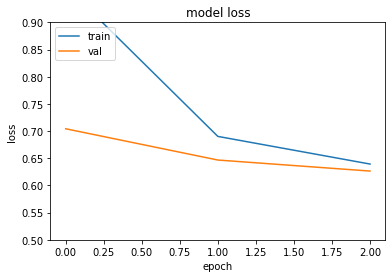

In [ ]:
from matplotlib import pyplot as plt

def plot_loss(history, min_y, max_y):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(min_y, max_y)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_loss(history, 0.5, 0.9)

### Test model

In [ ]:
!pip install evaluate -q
import evaluate

We implemented one function to see the answers that the model gives and another one for measuring the f1 score (SQUAD). 

In [45]:
def test_model(model: TFEncoderDecoderModel, dataset: datasets.arrow_dataset.Dataset, 
               max_length:int=20, idx_sample: Union[int, List[int]]=88, with_history=False) -> None:
    '''
        This function takes as input a dataset, it runs inference on the given
        model and then it prints the question, the real answer and the predicted
        one.
        Parameters:
            - model: transformers.models
                The model to run inference on.
            - dataset: datasets.arrow_dataset.Dataset
                The dataset from which the function takes the samples.
            - max_length: int
                It's the maximum length allowed during the generation.
            - idx_sample: int | list[int]
                If an integer is passed, then the function computes the answer
                for a single sample, otherwise for each sample specified in the
                list (through the index).
            - with_history: bool
                if to tokenize with the history or not.

        Return:
            The function simply prints the results without returning anything.
    '''
    if isinstance(idx_sample, int):
        idx_sample = [idx_sample]

    # Check if indices are without dataset bounds    
    max_ind = max(idx_sample)
    if max_ind >= len(dataset):
        print(f"Error: index {max_ind} is out of bounds (dataset of length {len(dataset)}.")
        return None

    for idx in idx_sample:
        inp_test, _, _ = tokenize_samples(dataset.select([idx]), tokenizer, with_history=with_history)

        greedy_output = model.generate(inp_test['input_ids'],
                                       attention_mask=inp_test['attention_mask'],
                                       max_length=max_length)# decoder_start_token_id=model.config.decoder.bos_token_id

        print(f"- The question {idx+1} is:\n\t{dataset[idx]['questions']}")
        print(f"- The actual answer is:\n\t{dataset[idx]['answers']}")
        print(f"- The predicted answer is:\n\t"
              f"{tokenizer.decode(greedy_output.numpy()[0], skip_special_tokens=True)}\n")

In [ ]:
test_model(model, dataset_test, max_length=50, idx_sample=[88, 0, 1188])

- The question 89 is:
	Was there a storm headed that way?
- The actual answer is:
	Yes
- The predicted answer is:
	no

- The question 1 is:
	What color was Cotton?
- The actual answer is:
	white
- The predicted answer is:
	a dog

- The question 1189 is:
	Is Lily old?
- The actual answer is:
	no
- The predicted answer is:
	yes



### Evaluate F1 score


In order to compute the squad f1 score we decided to use the [squad metric](https://huggingface.co/spaces/evaluate-metric/squad) from Huggingface. 

To avoid problem with RAM allocation (model.generate gave OOM error if we tried to run on the full test set), we generate batch of results and then we merge them together before computing the f1 score. 

In [63]:
def compute_f1_score(model: TFEncoderDecoderModel, X: dict, answers: List[str],
                     metric: evaluate.EvaluationModule, num_samples: Optional[int]=None,
                     max_length: int=20, batch_size: int=500, 
                     return_pred_answers: bool=False) -> Tuple[float, list]:
    '''
        This function takes as input a dataset, it runs inference on the given
        model and then it returns the F1 score metric.
        Parameters:
            - model: transformers.models
                The model to run inference on.
            - X: dict
                The structure that contains the input_ids and attention_mask, it
                is obtained doing 'variable.data' on an object of type
                transformers.tokenization_utils_base.BatchEncoding.
            - answers: list
                The array of strings of answers.
            - metric: evaluate.Metric
                It's the metric object to consider for the computation.
            - num_samples: int 
                The function takes from the samples the first 'num_samples'
                samples.
            - max_length: int
                It's the maximum length used during the generation
            - batch_size: int
                It's the batch size used to pass this number of answers to the 
                model (to avoid RAM allocation error).
            - return_pred_answers: bool
                If the function has to return the array of predicted answers.

        Returns:
            - (float, list)
                The f1 score and the array of predicted answers if return_pred_answers
                is True, only the f1 score and an empty list otherwise.
    '''
    # Take all the samples
    if num_samples == None:
        num_samples = len(answers)
    
    assert num_samples > batch_size, "ERROR: the batch size is greater than the number of samples."
    
    ids, att_mask = X['input_ids'][:num_samples], X['attention_mask'][:num_samples]

    num_step = num_samples//batch_size
    # The last batch may be smaller than the batch_size 
    last_batch_size = num_samples - (num_step*batch_size)

    predicted_answers = []
    for i in range(num_step+1):
        start = batch_size*(i)

        # Check if it has to run the last batch with a different size
        if i >= num_step:
            if last_batch_size > 0:
                batch_size = last_batch_size
            else:
                break

        out = model.generate(ids[start:start+batch_size], 
                             attention_mask=att_mask[start:start+batch_size],
                             max_length=max_length).numpy()

        refs = []
        preds = []
        for j in range(start, start+batch_size):
            # The model output is always of 'batch_size' elements so I need to
            # access the j - start element
            pred_string = tokenizer.decode(out[j-start], skip_special_tokens=True)
            if return_pred_answers:
                predicted_answers.append(pred_string)

            preds.append({'prediction_text':pred_string, 'id':str(j)})
            refs.append({'answers': {'text':[answers[j]],'answer_start':[0],},'id':str(j)})

        metric.add_batch(predictions=preds, references=refs)

    f1_score = metric.compute()
    assert f1_score is not None
    
    return f1_score['f1'], predicted_answers

In [ ]:
f1_metric = evaluate.load("squad")

f1_score, pred_answers = compute_f1_score(model, x_test, dataset_test['answers'],
                            f1_metric, num_samples=None, max_length=20, 
                            batch_size=1000, return_pred_answers=True)

print(f"The f1 score is {f1_score}")

The f1 score is 13.405680520723562


#### Compute top-5 better and worst questions
In the following function I compute the 5 best and 5 worst answers for the model.


In [50]:
# Group dialogues by source and report the worst 5 model errors for each source (w.r.t. SQUAD F1-score).
def decode_answ(sample, tokenizer):
    '''
        It decodes an array of numbers using the passed tokenizer.
    '''
    return tokenizer.decode(sample, skip_special_tokens=True)


def compute_f1_single_questions(predicted_answers: List[str], answers: List[str],
                                metric) -> List[int]:
    '''
        It computes the f1 score for each single question and returns the scores.
        Parameters:
            - predicted_answers: list
                The list of predicted answers (strings), that you can get from the 
                'compute_f1_score' function.
            - answers: list
                The list of actual answers.
            - metric:
                In this case a f1 squad metric is needed because we add the batches
                with a predefined schema.

        Returns:
            - list
                The list of f1 scores for each sample.
    '''
    scores = []

    # Compute the f1 score for each sample
    for pred, real in zip(predicted_answers, answers):
        pr={'prediction_text':pred, 'id':str(0)}
        re={'answers': {'text':[real],'answer_start':[0],},'id':str(0)}

        scores.append(metric.compute(predictions=[pr], references=[re])['f1'])

    return scores

In [51]:
from IPython.display import display
def compute_top_worst_k(scores, questions, answers, predictions, k=5):
    '''
        It computes the top and worst k questions (considering f1 score).
    '''
    idx_sort = np.argsort(scores)
    # We revert the list because the best score is the last one (highest)
    top_k = idx_sort[-k:][::-1]
    worst_k = idx_sort[:k]

    data_top = [(scores[i], questions[i], answers[i], predictions[i]) for i in top_k]
    data_worst = [(scores[i], questions[i], answers[i], predictions[i]) for i in worst_k]

    ranking_top = pd.DataFrame(data_top, columns=["F1 SCORE","Question","Answer","Predicted"])
    ranking_worst = pd.DataFrame(data_worst, columns=["F1 SCORE","Question","Answer","Predicted"])
    print(f"The top five f1 scores are:")
    display(ranking_top)
    print(f"\nThe worst five f1 scores are:")
    display(ranking_worst)

In [ ]:
f1_scores_quest, preds, answers = compute_f1_single_questions(model, tokenizer, x_test,
                                                        dataset_test['answers'],
                                                        f1_metric)

compute_top_worst_k(f1_scores_quest, df_final_evaluation['questions'], answers, preds, 5)

#### Compute f1 by source and dialogue

In [163]:
# TODO: maybe it's faster if we compute all the pred and ref and then
# we add_batch to the metric
def compute_f1_group(sample, metric):
    '''
        It computes the f1 score and the sum of the questions, answers and predicted
        answers for the samples within a same dialogue provided by a source.
    '''
    sumstr = []
    for i, (ans, pr) in enumerate(zip(sample['answers'], sample['predictions'])):
        pred = {'prediction_text':pr, 'id':str(i)}
        ref = {'answers': {'text':[ans],'answer_start':[0]},'id':str(i)}
        metric.add(prediction=pred, reference=ref)
        sumstr.append(f"Q:{sample['questions'].iloc[i]} A:{ans} P:{pr}")

    return pd.Series({'f1':metric.compute()['f1'], 'dialogue': sumstr})


def f1_score_source_dialogue(df, predictions, metric, drop_index=False):
    '''
        Returns a DataFrame with 2 additional columns, one for the f1 score at
        a dialogue level and another for the dialogue with the questions, the 
        answers and the predicted answers.
    '''
    assert len(predictions) == len(df), "ERROR: predictions array has not the same length of the DataFrame"
    
    new_df = df.copy()
    new_df['predictions'] = predictions

    new_df = new_df.groupby(['source','story'], sort=True) \
                    .apply(compute_f1_group, metric=metric) \
                    .reset_index(drop=drop_index)
    return new_df

In [ ]:
df_f1 = f1_score_source_dialogue(df_final_evaluation, pred_answers, f1_metric)
df_f1.head()

# Assignment Evaluation

The following assignment points will be awarded for each task as follows:

* Task 1, Pre-processing $\rightarrow$ 0.5 points.
* Task 2, Dataset Splitting $\rightarrow$ 0.5 points.
* Task 3 and 4, Models Definition $\rightarrow$ 1.0 points.
* Task 5 and 6, Models Training and Evaluation $\rightarrow$ 2.0 points.
* Task 7, Analysis $\rightarrow$ 1.0 points.
* Report $\rightarrow$ 1.0 points.

**Total** = 6 points <br>

We may award an additional 0.5 points for outstanding submissions. 
 
**Speed Bonus** = 0.5 extra points <br>

## Report

We apply the rules described in Assignment 1 regarding the report.
* Write a clear and concise report following the given overleaf template (**max 2 pages**).
* Report validation and test results in a table.$^1$
* **Avoid reporting** code snippets or copy-paste terminal outputs $\rightarrow$ **Provide a clean schema** of what you want to show

## Comments and Organization

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

Structure your code for readability and maintenance. If you work with Colab, use sections. 

This allows you to build clean and modular code, as well as easy to read and to debug (notebooks can be quite tricky time to time).

## FAQ (READ THIS!)

---

**Question**: Does Task 3 also include data tokenization and conversion step?

**Answer:** Yes! These steps are usually straightforward since ```transformers``` also offers a specific tokenizer for each model.

**Example**: 

```
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_text = tokenizer(text)
%% Alternatively
inputs = tokenizer.tokenize(text, add_special_tokens=True, max_length=min(max_length, 512))
input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
```

**Suggestion**: Hugginface's documentation is full of tutorials and user-friendly APIs.

---
---

**Question**: I'm hitting **out of memory error** when training my models, do you have any suggestions?

**Answer**: Here are some common workarounds:

1. Try decreasing the mini-batch size
2. Try applying a different padding strategy (if you are applying padding): e.g. use quantiles instead of maximum sequence length

---
---

## Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

## The End!

Questions?